In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Define the IMAGE_SHAPE, train_dir, validation_dir, and test_dir
IMAGE_SHAPE = (224, 224)
train_dir      = 'chess_test/train'
validation_dir = 'chess_test/val'
test_dir       = 'chess_test/test'

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir, shuffle=True, target_size=IMAGE_SHAPE)

Found 1200 images belonging to 4 classes.


In [5]:
validation_image_generator = ImageDataGenerator(rescale=1./255)
validation_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir, shuffle=True, target_size=IMAGE_SHAPE)

Found 360 images belonging to 4 classes.


In [6]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=test_dir, shuffle=True, target_size=IMAGE_SHAPE)

Found 40 images belonging to 4 classes.


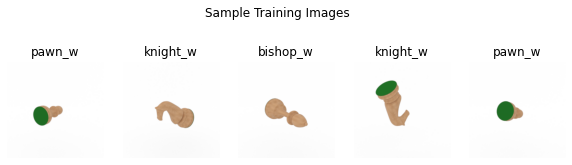

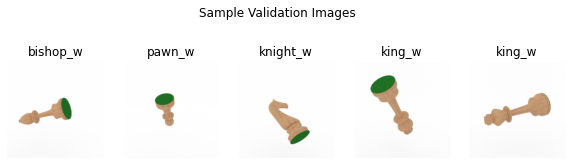

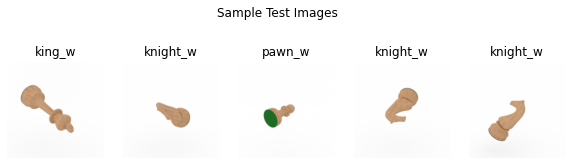

In [7]:
def display_samples(data_gen, title):
    # Make a lookup dictionary for class indexes
    classes = dict()
    for key, val in data_gen.class_indices.items():
        classes[val] = key

    # Get sample images and labels
    sample_images, sample_labels = next(data_gen)

    # Plot the images and labels
    plt.style.use({'figure.facecolor':'white'})
    plt.figure(figsize=(10,3))
    plt.subplots_adjust(hspace=0.5)
    for n in range(5):
        plt.subplot(1,5,n+1)
        plt.imshow(sample_images[n])
        plt.title(classes[np.argmax(sample_labels[n])])
        plt.axis('off')
    _ = plt.suptitle(title)

display_samples(train_data_gen, 'Sample Training Images')
display_samples(validation_data_gen, 'Sample Validation Images')
display_samples(test_data_gen, 'Sample Test Images')


In [8]:
num_classes = len(train_data_gen.class_indices)
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5',
                   trainable=False, input_shape=IMAGE_SHAPE + (3,)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Print out the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)



In [10]:
train_steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
val_steps_per_epoch = np.ceil(validation_data_gen.samples/validation_data_gen.batch_size)

# Train the model
epochs = 4
history = model.fit(train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=validation_data_gen,
                    validation_steps=val_steps_per_epoch)



Epoch 1/4
38/38 [==============================] - 21s 467ms/step - loss: 1.1577 - acc: 0.4818 - val_loss: 0.5737 - val_acc: 0.7722

In [11]:
# Make a lookup numpy array for class names
class_names = np.empty([len(test_data_gen.class_indices)], dtype=object, order='C')
for key, val in test_data_gen.class_indices.items():
    class_names[val] = key
# Get a test batch of images and labels
test_data_gen.reset()
image_batch, label_batch = next(test_data_gen)

# Predict the class of each image using our model
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)



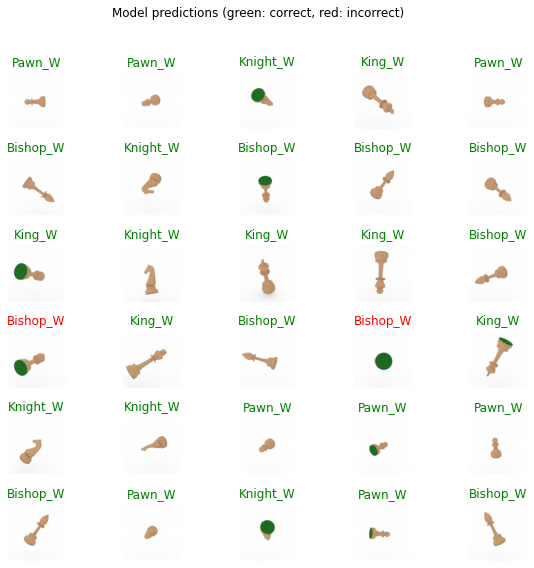

In [12]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(min(30, len(image_batch))):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

